In [1]:
%matplotlib inline
from pathlib import Path
import re

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 共通
from sklearn.linear_model import LogisticRegression

# 画像
import scipy.ndimage as ndimage
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 文章
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

スパムフィルタ用のデータセット

In [3]:
datapath = Path('spam_ham')
mail_pattern = re.compile(r'\d+')
test_size = 0.25

data_orig  = dict(easy_ham=[], hard_ham=[], spam=[])
data_train = dict(easy_ham=[], hard_ham=[], spam=[])
data_test  = dict(easy_ham=[], hard_ham=[], spam=[])

np.random.seed(539167)

for cls, mails in data_orig.items():
    # data_origへのデータの読み込み
    for path in (datapath / cls).iterdir():
        if mail_pattern.match(path.name):
            with open(path, 'r', encoding='latin') as src:
                mails.append(src.read())
    print(f"{cls:>8}: loaded {len(mails)} e-mails.")
    
    # train/testへのデータの分割
    data_train[cls], data_test[cls] = train_test_split(mails, test_size=test_size, random_state=539167)

easy_ham: loaded 2500 e-mails.
hard_ham: loaded 250 e-mails.
    spam: loaded 500 e-mails.


In [4]:
# データの整形用
def get_values_and_targets(data):
    values = data['spam'] + data['easy_ham'] + data['hard_ham']
    target = [True]*len(data['spam']) + [False]*(len(data['easy_ham']) + len(data['hard_ham']))
    target = np.array(target)
    return values, target

In [5]:
values_train, is_spam_train = get_values_and_targets(data_train)

In [6]:
print(data_orig['easy_ham'][0])

From fork-admin@xent.com  Tue Sep 24 10:48:44 2002
Return-Path: <fork-admin@xent.com>
Delivered-To: yyyy@localhost.spamassassin.taint.org
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id 4F72516F03
	for <jm@localhost>; Tue, 24 Sep 2002 10:48:42 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Tue, 24 Sep 2002 10:48:42 +0100 (IST)
Received: from xent.com ([64.161.22.236]) by dogma.slashnull.org
    (8.11.6/8.11.6) with ESMTP id g8O0TsC13135 for <jm@jmason.org>;
    Tue, 24 Sep 2002 01:29:54 +0100
Received: from lair.xent.com (localhost [127.0.0.1]) by xent.com (Postfix)
    with ESMTP id 6F07C294206; Mon, 23 Sep 2002 17:26:08 -0700 (PDT)
Delivered-To: fork@spamassassin.taint.org
Received: from mail.evergo.net (unknown [206.191.151.2]) by xent.com
    (Postfix) with SMTP id 8884929409A for <fork@xent.com>; Mon,
    23 Sep 2002 17:25:55 -0700 (PDT)
Received: (qmail 24684 invoked

In [7]:
data_orig['spam'][0].split()

['From',
 'Special_Offer-09192002-HTML@frugaljoe.330w.com',
 'Fri',
 'Sep',
 '20',
 '11:41:00',
 '2002',
 'Return-Path:',
 '<Special_Offer-09192002-HTML@frugaljoe.330w.com>',
 'Delivered-To:',
 'zzzz@localhost.spamassassin.taint.org',
 'Received:',
 'from',
 'localhost',
 '(jalapeno',
 '[127.0.0.1])',
 'by',
 'zzzzason.org',
 '(Postfix)',
 'with',
 'ESMTP',
 'id',
 '68DA116F03',
 'for',
 '<zzzz@localhost>;',
 'Fri,',
 '20',
 'Sep',
 '2002',
 '11:40:56',
 '+0100',
 '(IST)',
 'Received:',
 'from',
 'jalapeno',
 '[127.0.0.1]',
 'by',
 'localhost',
 'with',
 'IMAP',
 '(fetchmail-5.9.0)',
 'for',
 'zzzz@localhost',
 '(single-drop);',
 'Fri,',
 '20',
 'Sep',
 '2002',
 '11:40:56',
 '+0100',
 '(IST)',
 'Received:',
 'from',
 'webnote.net',
 '(mail.webnote.net',
 '[193.120.211.219])',
 'by',
 'dogma.slashnull.org',
 '(8.11.6/8.11.6)',
 'with',
 'ESMTP',
 'id',
 'g8JLiVC05050',
 'for',
 '<zzzz@jmason.org>;',
 'Thu,',
 '19',
 'Sep',
 '2002',
 '22:44:31',
 '+0100',
 'Received:',
 'from',
 'richard

In [8]:
def nullify_symbols(text):
    for ch in ".,:;!?-+*/=()[]{}<>~^#$@%&'\"_0123456789":
        text = text.replace(ch, ' ')
    return text

In [9]:
nullify_symbols(data_orig['spam'][0]).split()

['From',
 'Special',
 'Offer',
 'HTML',
 'frugaljoe',
 'w',
 'com',
 'Fri',
 'Sep',
 'Return',
 'Path',
 'Special',
 'Offer',
 'HTML',
 'frugaljoe',
 'w',
 'com',
 'Delivered',
 'To',
 'zzzz',
 'localhost',
 'spamassassin',
 'taint',
 'org',
 'Received',
 'from',
 'localhost',
 'jalapeno',
 'by',
 'zzzzason',
 'org',
 'Postfix',
 'with',
 'ESMTP',
 'id',
 'DA',
 'F',
 'for',
 'zzzz',
 'localhost',
 'Fri',
 'Sep',
 'IST',
 'Received',
 'from',
 'jalapeno',
 'by',
 'localhost',
 'with',
 'IMAP',
 'fetchmail',
 'for',
 'zzzz',
 'localhost',
 'single',
 'drop',
 'Fri',
 'Sep',
 'IST',
 'Received',
 'from',
 'webnote',
 'net',
 'mail',
 'webnote',
 'net',
 'by',
 'dogma',
 'slashnull',
 'org',
 'with',
 'ESMTP',
 'id',
 'g',
 'JLiVC',
 'for',
 'zzzz',
 'jmason',
 'org',
 'Thu',
 'Sep',
 'Received',
 'from',
 'richard',
 'w',
 'com',
 'richard',
 'w',
 'com',
 'by',
 'webnote',
 'net',
 'with',
 'ESMTP',
 'id',
 'WAA',
 'for',
 'zzzz',
 'spamassassin',
 'taint',
 'org',
 'Thu',
 'Sep',
 'Mes

1, 2文字の単語を除去する関数を作成。

In [10]:
def format_words(words, min_length=3):
    return [word.lower() for word in words if len(word) >= min_length]

In [11]:
format_words(nullify_symbols(data_orig['spam'][0]).split())

['from',
 'special',
 'offer',
 'html',
 'frugaljoe',
 'com',
 'fri',
 'sep',
 'return',
 'path',
 'special',
 'offer',
 'html',
 'frugaljoe',
 'com',
 'delivered',
 'zzzz',
 'localhost',
 'spamassassin',
 'taint',
 'org',
 'received',
 'from',
 'localhost',
 'jalapeno',
 'zzzzason',
 'org',
 'postfix',
 'with',
 'esmtp',
 'for',
 'zzzz',
 'localhost',
 'fri',
 'sep',
 'ist',
 'received',
 'from',
 'jalapeno',
 'localhost',
 'with',
 'imap',
 'fetchmail',
 'for',
 'zzzz',
 'localhost',
 'single',
 'drop',
 'fri',
 'sep',
 'ist',
 'received',
 'from',
 'webnote',
 'net',
 'mail',
 'webnote',
 'net',
 'dogma',
 'slashnull',
 'org',
 'with',
 'esmtp',
 'jlivc',
 'for',
 'zzzz',
 'jmason',
 'org',
 'thu',
 'sep',
 'received',
 'from',
 'richard',
 'com',
 'richard',
 'com',
 'webnote',
 'net',
 'with',
 'esmtp',
 'waa',
 'for',
 'zzzz',
 'spamassassin',
 'taint',
 'org',
 'thu',
 'sep',
 'message',
 'waa',
 'webnote',
 'net',
 'received',
 'richard',
 'com',
 'powermta',
 'thu',
 'sep',
 '

### 特徴量ベクトルの作成


In [12]:
# data_orig['spam'][0] がリストに入っている
vocab = CountVectorizer(token_pattern=r'[a-zA-Z]{3,}').fit([data_orig['spam'][0]])

In [13]:
# 単語リストの表示
vocab.get_feature_names()

['about',
 'activate',
 'align',
 'all',
 'amazon',
 'amp',
 'amplification',
 'and',
 'any',
 'anywhere',
 'approved',
 'are',
 'arial',
 'asp',
 'autonumber',
 'based',
 'because',
 'best',
 'better',
 'bgcolor',
 'big',
 'bin',
 'blank',
 'bmfp',
 'body',
 'border',
 'bordercolor',
 'browser',
 'calls',
 'can',
 'cancelling',
 'cdw',
 'cellpadding',
 'cellspacing',
 'center',
 'certified',
 'chat',
 'class',
 'click',
 'cnietonten',
 'collapse',
 'color',
 'colspan',
 'com',
 'compare',
 'comparisons',
 'compatible',
 'conference',
 'content',
 'conversations',
 'custid',
 'cut',
 'date',
 'default',
 'delivered',
 'depot',
 'detail',
 'distance',
 'div',
 'dogma',
 'dot',
 'drop',
 'edc',
 'eid',
 'else',
 'email',
 'envelope',
 'error',
 'esmtp',
 'even',
 'ever',
 'exec',
 'face',
 'factorydirectdeals',
 'faq',
 'fetchmail',
 'ffcc',
 'ffffff',
 'following',
 'font',
 'for',
 'fri',
 'friends',
 'from',
 'frugaljoe',
 'get',
 'gif',
 'giftshop',
 'have',
 'head',
 'headset',
 'he

In [14]:
print(vocab.transform([data_orig['spam'][0]]))

  (0, 0)	1
  (0, 1)	1
  (0, 2)	39
  (0, 3)	2
  (0, 4)	2
  (0, 5)	1
  (0, 6)	1
  (0, 7)	6
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	40
  (0, 13)	1
  (0, 14)	2
  (0, 15)	1
  (0, 16)	1
  (0, 17)	1
  (0, 18)	2
  (0, 19)	17
  (0, 20)	1
  (0, 21)	2
  (0, 22)	5
  (0, 23)	2
  (0, 24)	3
  :	:
  (0, 233)	1
  (0, 234)	5
  (0, 235)	44
  (0, 236)	1
  (0, 237)	1
  (0, 238)	4
  (0, 239)	2
  (0, 240)	1
  (0, 241)	1
  (0, 242)	4
  (0, 243)	1
  (0, 244)	1
  (0, 245)	77
  (0, 246)	1
  (0, 247)	7
  (0, 248)	1
  (0, 249)	1
  (0, 250)	2
  (0, 251)	29
  (0, 252)	9
  (0, 253)	10
  (0, 254)	1
  (0, 255)	1
  (0, 256)	8
  (0, 257)	1


In [15]:
vocab    = CountVectorizer(binary=True, token_pattern=r'[a-zA-Z]{3,}')
features = vocab.fit_transform(values_train)

In [16]:
# print() で特徴量データを表示
print(features)

  (0, 93231)	1
  (0, 35837)	1
  (0, 13901)	1
  (0, 5046)	1
  (0, 28137)	1
  (0, 52531)	1
  (0, 70026)	1
  (0, 25253)	1
  (0, 24140)	1
  (0, 88295)	1
  (0, 88066)	1
  (0, 27397)	1
  (0, 15196)	1
  (0, 52573)	1
  (0, 53595)	1
  (0, 100382)	1
  (0, 77357)	1
  (0, 78128)	1
  (0, 3128)	1
  (0, 15409)	1
  (0, 27592)	1
  (0, 83026)	1
  (0, 14570)	1
  (0, 35774)	1
  (0, 17473)	1
  :	:
  (2436, 56617)	1
  (2436, 55182)	1
  (2436, 83704)	1
  (2436, 83346)	1
  (2436, 20447)	1
  (2436, 21249)	1
  (2436, 82916)	1
  (2436, 27518)	1
  (2436, 41536)	1
  (2436, 28993)	1
  (2436, 25386)	1
  (2436, 99650)	1
  (2436, 70736)	1
  (2436, 44514)	1
  (2436, 76525)	1
  (2436, 66308)	1
  (2436, 86898)	1
  (2436, 84258)	1
  (2436, 53455)	1
  (2436, 18374)	1
  (2436, 68025)	1
  (2436, 77541)	1
  (2436, 14605)	1
  (2436, 52506)	1
  (2436, 29661)	1


In [19]:
# toarray() で特徴量を配列形式で表示
features.toarray()

MemoryError: 

In [18]:
# shapeを確認
features.shape

(2437, 109596)

### フィルタアルゴリズムの作成


In [19]:
model = LogisticRegression(solver='saga', max_iter=3000, random_state=539167).fit(features, is_spam_train)

In [20]:
values_test, is_spam_test = get_values_and_targets(data_test)
pred_test = model.predict(vocab.transform(values_test))

In [21]:
validation = (pred_test == is_spam_test)
size    = validation.size
correct = np.count_nonzero(validation)
print(f"{correct}/{size} correct ({correct*100/size:.3f}%)")

808/813 correct (99.385%)


In [22]:
for cls in ('spam', 'easy_ham', 'hard_ham'):
    _values  = data_test[cls]
    _is_spam = [(cls == 'spam')]*len(_values)
    _pred    = model.predict(vocab.transform(_values))
    _valid   = (_pred == _is_spam)
    _size    = _valid.size
    _correct = np.count_nonzero(_valid)
    print(f"{cls:>8s}: {_correct:>3d}/{_size:>3d} correct ({_correct*100/_size:.3f}%)")

    spam: 125/125 correct (100.000%)
easy_ham: 625/625 correct (100.000%)
hard_ham:  58/ 63 correct (92.063%)


## 画像データの機械学習 (Digits)


In [23]:
digits = datasets.load_digits()

In [24]:
for key in digits.keys():
    print(key)

data
target
target_names
images
DESCR


In [25]:
digits['data'].shape

(1797, 64)

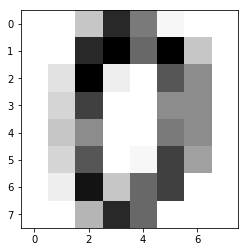

In [26]:
plt.imshow(digits['data'][0].reshape((8,8)), cmap=plt.get_cmap('Greys'))

In [27]:
test_size = 0.25
values_train, values_test, labels_train, labels_test = train_test_split(digits['data'], digits['target'], 
                                                                        test_size=test_size, random_state=539167)

In [28]:
model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=3000, 
                           random_state=539167).fit(values_train, labels_train)

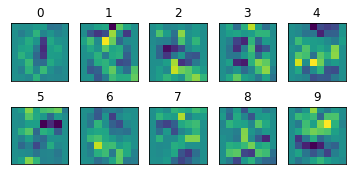

In [29]:
coefs = model.coef_
fig, axes = plt.subplots(2,5,sharex=True,sharey=True, figsize=(6, 3))
for i in range(2):
    for j in range(5):
        z = i*5+j
        axes[i,j].imshow(coefs[z].reshape((8,8)), cmap=plt.get_cmap('viridis'), vmin=-.5, vmax=.5)
        axes[i,j].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
        axes[i,j].set_title(z)
plt.subplots_adjust(hspace=.05)
fig.savefig('images/digits_rawregression_params.png')
plt.show()

In [30]:
pred_test  = model.predict(values_test)
validation = (pred_test == labels_test)
size       = validation.size
correct    = np.count_nonzero(validation)
print(f"{correct}/{size} correct ({correct*100/size:.3f}%)")

433/450 correct (96.222%)


### 主成分分析(PCA)

In [31]:
extractor = PCA(n_components=8, random_state=539167)
features_train = extractor.fit_transform(values_train)

In [32]:
# shapeを確認
extractor.components_.shape

(8, 64)

In [33]:
# 8x8にreshape
eigen = extractor.components_.reshape((-1,8,8))
eigen.min(), eigen.max()

(-0.438219724329712, 0.3781886900057748)

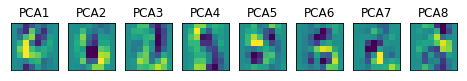

In [34]:
# 描画する
fig, axes = plt.subplots(1,8,sharex=True,sharey=True, figsize=(8, 3))
for i in range(1):
    for j in range(8):
        z = i*8+j
        axes[j].imshow(eigen[z], cmap=plt.get_cmap('viridis'), vmin=-.3, vmax=.3)
        axes[j].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
        axes[j].set_title(f"PCA{z+1}")
plt.subplots_adjust(hspace=.05)
fig.savefig('images/digits_pca_eigenvectors.png')
plt.show()

ロジスティックモデルで分類

In [35]:
model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, 
                           random_state=539167).fit(features_train, labels_train)

In [36]:
features_test = extractor.transform(values_test)
pred_test  = model.predict(features_test)
validation = (pred_test == labels_test)
size       = validation.size
correct    = np.count_nonzero(validation)
print(f"{correct}/{size} correct ({correct*100/size:.3f}%)")

402/450 correct (89.333%)


### 畳み込み(Convolution)

In [37]:
def calc_gradient(values, imgshape=(8,8)):
    """x軸方向、y軸方向の勾配を返す"""
    w, h = imgshape
    n_features = w*h
    as_img = values.reshape((-1,)+imgshape)
    
    opts   = dict(mode='constant', cval=0.0)
    grad_x = ndimage.sobel(as_img, axis=-1, **opts)
    grad_y = ndimage.sobel(as_img, axis=-2, **opts)
    return grad_x.reshape((-1, n_features)), grad_y.reshape((-1, n_features))

def as_features(values):
    gx, gy = calc_gradient(values)
    return np.concatenate([gx, gy], axis=-1)

In [38]:
gx, gy = calc_gradient(values_train)
features_train = as_features(values_train)
print(features_train.shape)

(1347, 128)


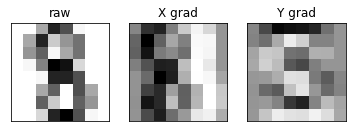

In [39]:
# 画像として描画する
i = 0
amp = 128
fig, axes = plt.subplots(1,3)
axes[0].imshow(values_train[i].reshape((8,8)), cmap=plt.get_cmap('Greys'))
axes[1].imshow(gx[i].reshape((8,8)), cmap=plt.get_cmap('Greys'), vmin=-amp, vmax=amp)
axes[2].imshow(gy[i].reshape((8,8)), cmap=plt.get_cmap('Greys'), vmin=-amp, vmax=amp)
axes[0].set_title("raw")
axes[1].set_title("X grad")
axes[2].set_title("Y grad")
for ax in axes:
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
fig.savefig('images/digits_grad_sample.png')
plt.show()

ロジスティックモデル

In [40]:
model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, 
                           random_state=539167).fit(features_train, labels_train)

features_test = as_features(values_test)
pred_test  = model.predict(features_test)
validation = (pred_test == labels_test)
size       = validation.size
correct    = np.count_nonzero(validation)
print(f"{correct}/{size} correct ({correct*100/size:.3f}%)")

324/450 correct (72.000%)


さらに精度が悪くなりました。。。

### k-平均法(K-means)

In [41]:
# KMeansを実行する
n_clusters = len(digits['target_names'])
model = KMeans(n_clusters=n_clusters, n_init=30, random_state=539167).fit(values_train)

In [42]:
# 画像として表示するためreshape
centers = model.cluster_centers_.reshape((-1, 8, 8))

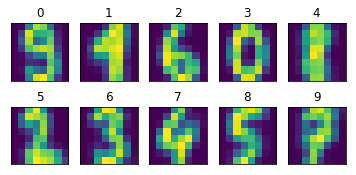

In [43]:
# 画像として描画する
fig, axes = plt.subplots(2,5,sharex=True,sharey=True, figsize=(6, 3))
for i in range(2):
    for j in range(5):
        z = i*5+j
        axes[i,j].imshow(centers[z], cmap=plt.get_cmap('viridis'))
        axes[i,j].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
        axes[i,j].set_title(z)
plt.subplots_adjust(hspace=.05)
fig.savefig('images/digits_kmeans_centers.png')
plt.show()

In [44]:
# クラスタを割り振る
pred_train = model.predict(values_train)
names      = sorted(set(labels_train))

# 割り振りに使う配列。i番目のクラスタが対応するラベルが、annotation[i]に入る
annotation = np.empty(n_clusters, dtype=int)
for i in range(n_clusters):
    cluster = (pred_train == i)
    counts  = np.array([np.count_nonzero(labels_train[cluster] == name) for name in names])
    annotation[i] = names[counts.argmax()]

    # アノテーションの出力
    print(f"cluster{i} -> '{annotation[i]}'")

cluster0 -> '9'
cluster1 -> '1'
cluster2 -> '6'
cluster3 -> '0'
cluster4 -> '8'
cluster5 -> '2'
cluster6 -> '3'
cluster7 -> '4'
cluster8 -> '5'
cluster9 -> '7'


In [45]:
valid_train = (annotation[pred_train] == labels_train)
size       = valid_train.size
correct    = np.count_nonzero(valid_train)
print(f"training data: {correct}/{size} correct ({correct*100/size:.3f}%)")

pred_test  = model.predict(values_test)
valid_test = (annotation[pred_test] == labels_test)
size       = valid_test.size
correct    = np.count_nonzero(valid_test)
print(f" testing data: {correct}/{size} correct ({correct*100/size:.3f}%)")

training data: 1070/1347 correct (79.436%)
 testing data: 361/450 correct (80.222%)
